**Data-Driven Engineering Project: Prediction of a pendulum motion**

Regression of the trajectory

Now Y (length, mass, damping, theta0, omega0) is the input and we would like to get the trajectory as regression output.

In [ ]:
from google.colab import files

# uploaded = files.upload() # upload directly but can take some time

from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)


Mounted at /content/gdrive/


In [ ]:
import scipy.io
from scipy.integrate import odeint
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

X = scipy.io.loadmat('/content/gdrive/MyDrive/DataDrivenEngineering_Data/X.mat')
Y = scipy.io.loadmat('/content/gdrive/MyDrive/DataDrivenEngineering_Data/Y.mat')
Y = Y['Y'].T        # import the variable named 'Y' from the .mat file
X = X['X'].T

# Transpose to get the samples on the rows and features on columns

print(X.shape)
print(Y.shape)


(6075, 10001)
(6075, 5)


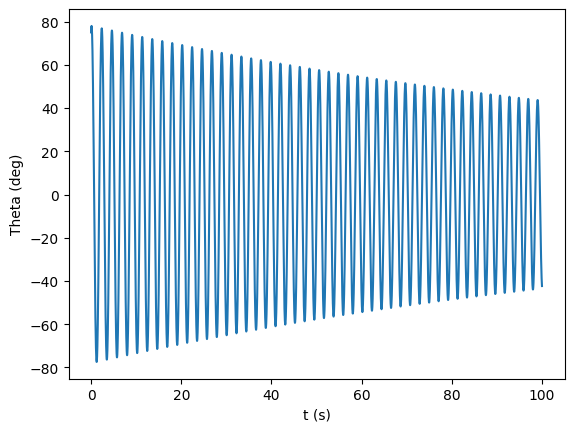

In [ ]:
# Plot one observation with its labels
observation = 6050

dt = 0.01  # time step
t_end = 100  # end time in seconds
tspan = np.arange(0, t_end + dt, dt)

plt.plot(tspan,X[observation,:]*180/np.pi)
plt.ylabel('Theta (deg)')
plt.xlabel('t (s)')
plt.show()

In [ ]:
# Split the data into train and test sets and permutates randomly
X_train, X_test, y_train, y_test = train_test_split(Y, X, test_size=0.2, random_state=5)

# Scale the train and test parts
scaler = StandardScaler()
X0_train = scaler.fit_transform(X_train)
X0_test = scaler.transform(X_test)

print(y_train.shape)

# scaling and spliting cannot be interchanged because by scaling you use all of the data that you input, 
# such that you insert some knowledge of the test data!

(4860, 10001)


In [ ]:
# Build a linear neural network using the tensorflow sequential model
# https://www.tensorflow.org/guide/keras/sequential_model

output_shape = y_train.shape[1]
input_shape = (X_train.shape[1],)

# Fully-connected neural network
model = tf.keras.Sequential([
    # # Let's start with input directly connected to output
    # tf.keras.layers.Dense(output_shape, input_shape=input_shape, activation='linear')

    # # Let's try adding 1 hidden layer
    # tf.keras.layers.Dense(16,input_shape=input_shape, name='Hidden1',activation = 'tanh'), # First hidden Layer
    # tf.keras.layers.Dense(output_shape, name ='Output',activation='linear')

    # # Let's try adding 2 hidden layers
    # tf.keras.layers.Dense(10,input_shape=input_shape, name='Hidden1',activation = 'linear'), # First hidden Layer
    # tf.keras.layers.Dense(10, activation="linear", name="Hidden2"), # Second hidden Layer
    # tf.keras.layers.Dense(output_shape, name ='Output',activation='linear')

    # Let's try adding 3 hidden layers
    tf.keras.layers.Dense(16,input_shape=input_shape, name='Hidden1',activation = 'elu'), # First hidden Layer
    tf.keras.layers.Dense(20, activation="tanh", name="Hidden2"), # Second hidden Layer
    tf.keras.layers.Dense(20, activation="linear", name="Hidden3"), # third hidden Layer
    tf.keras.layers.Dense(output_shape, name ='Output',activation='linear')

    # # Let's try adding 4 hidden layers
    # tf.keras.layers.Dense(12,input_shape=input_shape, name='Hidden1',activation = 'elu'), # First hidden Layer
    # tf.keras.layers.Dense(24, activation="tanh", name="Hidden2"), # Second hidden Layer
    # tf.keras.layers.Dense(48, activation="tanh", name="Hidden3"), # Third hidden Layer
    # tf.keras.layers.Dense(96, activation="relu", name="Hidden4"), # Fourth hidden Layer
    # tf.keras.layers.Dense(output_shape, name ='Output',activation='linear')
])

model.summary()
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 16)                96        
                                                                 
 Hidden2 (Dense)             (None, 20)                340       
                                                                 
 Hidden3 (Dense)             (None, 20)                420       
                                                                 
 Output (Dense)              (None, 10001)             210021    
                                                                 
Total params: 210,877
Trainable params: 210,877
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X0_train, y_train, 
                    epochs=25, 
                    validation_data=(X0_test, y_test))

Epoch 1/150
152/152 [==============================] - 2s 13ms/step - loss: 0.0585 - accuracy: 0.1280 - val_loss: 0.0624 - val_accuracy: 0.1226
Epoch 2/150
152/152 [==============================] - 2s 13ms/step - loss: 0.0581 - accuracy: 0.1276 - val_loss: 0.0622 - val_accuracy: 0.1185
Epoch 3/150
152/152 [==============================] - 1s 10ms/step - loss: 0.0577 - accuracy: 0.1265 - val_loss: 0.0619 - val_accuracy: 0.1407
Epoch 4/150
152/152 [==============================] - 1s 7ms/step - loss: 0.0573 - accuracy: 0.1235 - val_loss: 0.0614 - val_accuracy: 0.1292
Epoch 5/150
152/152 [==============================] - 1s 6ms/step - loss: 0.0570 - accuracy: 0.1292 - val_loss: 0.0609 - val_accuracy: 0.1284
Epoch 6/150
152/152 [==============================] - 1s 6ms/step - loss: 0.0566 - accuracy: 0.1253 - val_loss: 0.0605 - val_accuracy: 0.1317
Epoch 7/150
152/152 [==============================] - 1s 6ms/step - loss: 0.0562 - accuracy: 0.1274 - val_loss: 0.0601 - val_accuracy: 0.1

38/38 - 0s - loss: 0.5554 - accuracy: 0.0313 - 193ms/epoch - 5ms/step
test loss: 0.5553823709487915
test accuracy: 0.03127571940422058


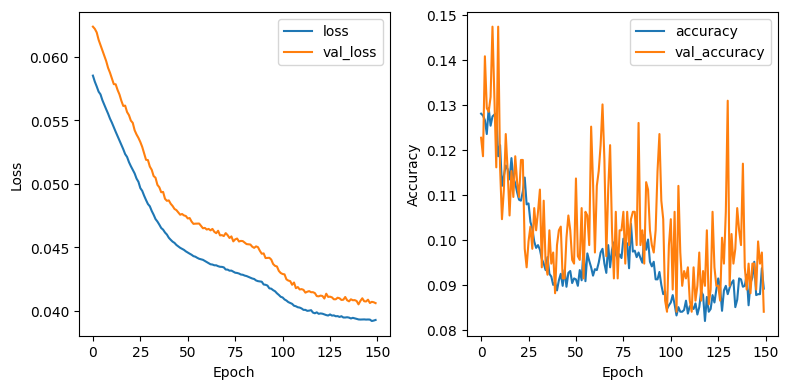

In [ ]:
# We can check the training history
# when the loss doesn't change anymore -> model has reached maximum accuracy
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('test loss:', test_loss)
print('test accuracy:', test_acc)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label = 'val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label = 'val_accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

fig.tight_layout()
plt.show()

# graphs very important when training, loss can go down and val_loss can stay same
# model is getting overfit 
# select number of epochs on validation loss !!!

In [ ]:
# save the figure as an EPS file
fig.savefig('trainingHistory_regr.eps', format='eps')
# download the figure to your local machine
from google.colab import files
files.download('trainingHistory_regr.eps')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Predicting the values (y_train etc has to be changed to use this + use loss = 'srm' ofzoeits)
predictions = model.predict(X_test)

print(predictions.shape)

38/38 [==============================] - 0s 2ms/step
(1215, 10001)


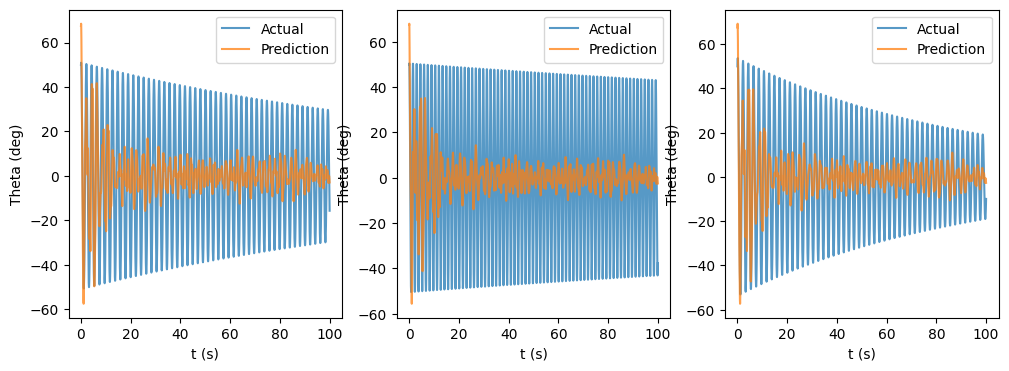

In [ ]:
n_rows = 1
n_cols = 3
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4))

for i in range(n_rows*n_cols):
    rand_index = np.random.randint(0, len(y_test))
    axs[i].plot(tspan, y_test[rand_index]*180/np.pi, label='Actual', alpha=0.75)
    axs[i].plot(tspan, predictions[rand_index]*180/np.pi, label='Prediction', alpha=0.75)
    axs[i].legend()
    axs[i].set_xlabel('t (s)')
    axs[i].set_ylabel('Theta (deg)')

plt.show()

In [ ]:
# save the figure as an EPS file
fig.savefig('results_regr.eps', format='eps')
# download the figure to your local machine
from google.colab import files
files.download('results_regr.eps')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>